In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb

pd.set_option('display.max_columns', None)

### user defined functions

In [2]:
# define functions to be used throughout

def clean_data(df, clean_var_list):
    
    # remove odd characters from observations
    for i in df.select_dtypes(include=object).columns:
        df[i] = df[i].str.replace('z_', '')
      
    # remove $ sign from amount columns and convert to float 
    for var in clean_var_list:
        df.loc[df[var].isna(), var] = 0
        df[var] = pd.to_numeric(df[var].str.replace(r'[^\d\.]', ''), errors='coerce')
    
    return df
        

def preprocess_bin_data(df, binary_var_list):
    
    # convert binary character variables to [0, 1]  
    for i in binary_var_list:
        df[i] = pd.Categorical(df[i], ordered=None)
        df[i] = df[i].cat.codes
        
    return df
        
        
def preprocess_cat_data(df, categorical_var_list):
    
    # one-hot encode categorical variables so can be used within model
    for i in categorical_var_list:
        df.loc[df[i].isna(), i] = 'UNKOWN'
        df = df.merge(pd.get_dummies(df[i]), how='left', left_index=True,  right_index=True)
        
    return df.drop(columns=cat_vars)


def preprocess_con_data(df, continuous_var_list):
    
    # replace null values within continuous columns with median value of variable    
    for i in continuous_var_list:
        df.loc[df[i].isna(), i] = df[i].median()
    
    # standardize continous variables so all reduced to suitable range 
    for i in continuous_var_list:
        df[i] = df.loc[:, [i]].apply(lambda x: (x - x.mean()) / (max(x) - min(x)))

    return df

### read in data

In [3]:
# read in test and training dataframes, append and check shape remains consistent
train_df = pd.read_csv('train_auto.csv')
test_df = pd.read_csv('test_auto.csv')

auto_df = pd.concat([train_df, test_df])

auto_df.sort_values(by='INDEX', inplace=True)
auto_df.reset_index(inplace=True, drop=True)

print(train_df.shape, test_df.shape, auto_df.shape, sep='\n')

(8161, 26)
(2141, 26)
(10302, 26)


In [4]:
# auto_df.sample(3)

In [5]:
# auto_df.describe()

### data preprocessing

In [6]:
# create additional flag variable to indicate if old claim exists
auto_df.loc[auto_df['OLDCLAIM'] != 0, 'OLDCLAIM_FLAG'] = 1
auto_df.loc[auto_df['OLDCLAIM_FLAG'].isna(), 'OLDCLAIM_FLAG'] = 0

# replace negative vehicle age with zero
auto_df.loc[auto_df['CAR_AGE'] < 0, 'CAR_AGE'] = 0 

In [7]:
# define lists of variables to be passed through functions
clean_vars = ['INCOME','HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
binary_vars = ['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'URBANICITY', 'REVOKED']
cat_vars = ['EDUCATION', 'JOB', 'CAR_TYPE']
cont_vars = ['AGE', 'INCOME', 'HOME_VAL', 'BLUEBOOK', 'TRAVTIME',  'OLDCLAIM', 'YOJ', 'CAR_AGE','TIF', 'MVR_PTS']

In [8]:
# perform preprocess on observations as defined by user functions
auto_df = clean_data(auto_df, clean_vars)
auto_df = preprocess_bin_data(auto_df, binary_vars)
auto_df = preprocess_cat_data(auto_df, cat_vars)
auto_df = preprocess_con_data(auto_df, cont_vars)

# rename columns headings to allow passing into model
auto_df.columns = auto_df.columns.str.replace('<', 'lt_').str.replace(' ', '_')

In [9]:
# auto_df.head()

In [10]:
# auto_df[cont_vars].describe()

In [11]:
# for i in cont_vars:
#     print(i)
#     plt.hist(auto_df.loc[auto_df[i].notna(), i])
#     plt.show();

### modelling and prediction of data

In [12]:
# merge pre-processed data back to df to split back into original train/test dataframes
X = train_df[['INDEX']].merge(auto_df, how='inner', on='INDEX').drop(columns=['TARGET_AMT', 'INDEX', 'TARGET_FLAG'])
y = train_df[['INDEX']].merge(auto_df, how='inner', on='INDEX')[['TARGET_FLAG']].astype(int)

# split training dataset into train/test and seperate into predictor and predicted to allow for modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
y.groupby(['TARGET_FLAG'])['TARGET_FLAG'].count()  # unbalanced

TARGET_FLAG
0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

In [14]:
# define model and create dictionay of parameters for grid search to tune 
model = xgb.XGBClassifier(use_label_encoder=True)

parameters = {
             "eta"              : [0.01, 0.05, 0.10] ,
             "max_depth"        : [5, 10, 15, 25, 50],
             "min_child_weight" : [3, 5, 7],
             "gamma"            : [0.0, 0.1, 0.4 ],
             "colsample_bytree" : [0.3, 0.5 , 0.7, 0.9],
             "learning_rate"    : [0.01, 0.05, 0.05]
             }

grid_search = GridSearchCV( model,
                            parameters, 
                            n_jobs=-1,
                            scoring="neg_log_loss",
                            cv=3)

#### no need to run cell - paramaters hard coded below

In [15]:
# iterate through combination of above parameters and find best model estimator 
grid_search.fit(X_train, y_train['TARGET_FLAG'].ravel())
grid_search.best_estimator_

# assign best parameters to model and fit model on training data
model = grid_search.best_estimator_
model.fit(X_train, y_train['TARGET_FLAG'].ravel());

C:\Users\Cody\.julia\conda\3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.01, gamma=0.0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# assign best parameters to model and fit model on training data
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=0.7, eta=0.01, gamma=0.0,
                      gpu_id=-1, importance_type='gain', interaction_constraints='',
                      learning_rate=0.05, max_delta_step=0, max_depth=5,
                      min_child_weight=7, missing=False, monotone_constraints='()',
                      n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
                      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                      tree_method='exact', validate_parameters=1, verbosity=Nonee)

model.fit(X_train, y_train['TARGET_FLAG'].ravel())

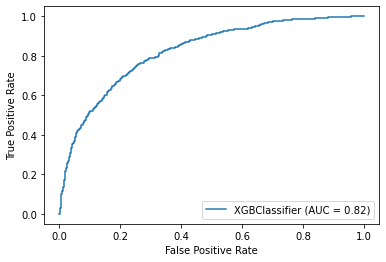

In [19]:
# plot roc curve to visualize performance of model on test data
metrics.plot_roc_curve(model, X_test, y_test);

In [21]:
# print confusion matrix of results
y_pred = model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[1700,  101],
       [ 384,  264]], dtype=int64)

### predict on provided test dataset with unknown outcome variable 

In [22]:
# merge pre-processed data back to df to split back into original train/test dataframes
X = test_df[['INDEX']].merge(auto_df, how='inner', on='INDEX').drop(columns=['TARGET_AMT', 'INDEX', 'TARGET_FLAG'])

y_pred = model.predict(X)

In [23]:
# assign predicted outcome back to original index
y_pred_df = pd.DataFrame(pd.Series(y_pred)).rename(columns={0: 'pred_outcome'})
y_pred_df = test_df[['INDEX']].merge(y_pred_df, how='inner', left_index=True,  right_index=True)